In [ ]:
import json
import httpx
import logging

import matplotlib.pyplot as plt
import pandas as pd

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('notebook')
logger.setLevel(logging.DEBUG)

In [2]:
QUERY = '''
(
 (soil AND {!surround v="(carbon OR CO2) 4N (sequester OR sequestering OR sequestration OR storage OR remove OR removing OR removal)"} AND (biochar OR bio-char OR manage OR management OR managing OR practice OR practicing OR restoration OR land-use)) OR
 ((soil AND {!surround v="((carbon OR CO2) 4N (sequester OR sequestering OR sequestration OR storage OR remove OR removing OR removal))"}) AND ("climate change" OR "global warming") ) OR
 ("land management" AND {!surround v="(carbon OR CO2) 4N (sequester OR sequestering OR sequestration OR storage OR remove OR removing OR removal)"}) OR
 ("carbon farming") OR
 ("soil carbon management" OR "soil carbon sequestration") OR
 ("soil organic carbon" AND restoration)
)
'''
QUERY_REVIEWS = '''
title: (review OR "systematic map" OR "meta analysis" OR "meta-analysis" OR "evidence synthesis")
'''


async def fetch_data(query, dst, fq=None):
    params = {
        'q': query,
        'q.op': 'AND',
        'df': 'title_abstract',
        'useParams': '',
        'defType': 'lucene',
        'rows': 100,
        'fq': fq,
        'sort': 'id desc',
        'cursorMark': '*'
    }
    with open(dst, 'w') as f:
        async with httpx.AsyncClient() as client:
            batch_i = 0
            num_docs_cum = 0
            while True:
                batch_i += 1
                logger.info(f'Running query for batch {batch_i} with cursor "{params["cursorMark"]}"')
                request = await client.post(f'http://srv-mcc-apsis-rechner:8983/solr/openalex/select', data=params,
                                            timeout=60)
                response = request.json()

                next_curser = response.get('nextCursorMark')
                params['cursorMark'] = next_curser
                n_docs_total = response['response']['numFound']
                batch_docs = response['response']['docs']
                n_docs_batch = len(batch_docs)
                num_docs_cum += n_docs_batch

                if n_docs_total > 0:
                    logger.debug(
                        f'Current progress: {num_docs_cum:,}/{n_docs_total:,}={num_docs_cum / n_docs_total:.2%} docs')

                if len(batch_docs) == 0:
                    logger.info('No documents in this batch, assuming to be done!')
                    break

                if next_curser is None:
                    logger.info('Did not receive a `nextCursorMark`, assuming to be done!')
                    break

                logger.debug(f'Received response from OpenAlex: {response["responseHeader"]}')

                for doc in response['response']['docs']:
                    f.write(json.dumps(doc) + '\n')


await fetch_data(QUERY, 'data/query_review.jsonl', fq=QUERY_REVIEWS)
await fetch_data(QUERY, 'data/query_all.jsonl')

2024-03-13 20:21:18,321 [INFO] notebook: Running query for batch 1 with cursor "*"
2024-03-13 20:21:18,780 [INFO] httpx: HTTP Request: POST http://srv-mcc-apsis-rechner:8983/solr/openalex/select "HTTP/1.1 200 OK"
2024-03-13 20:21:18,899 [DEBUG] notebook: Current progress: 100/717=13.95% docs
2024-03-13 20:21:18,901 [DEBUG] notebook: Received response from OpenAlex: {'zkConnected': True, 'status': 0, 'QTime': 424, 'params': {'q': '\n(\n (soil AND {!surround v="(carbon OR CO2) 4N (sequester OR sequestering OR sequestration OR storage OR remove OR removing OR removal)"} AND (biochar OR bio-char OR manage OR management OR managing OR practice OR practicing OR restoration OR land-use)) OR\n ((soil AND {!surround v="((carbon OR CO2) 4N (sequester OR sequestering OR sequestration OR storage OR remove OR removing OR removal))"}) AND ("climate change" OR "global warming") ) OR\n ("land management" AND {!surround v="(carbon OR CO2) 4N (sequester OR sequestering OR sequestration OR storage OR rem

In [4]:
with open('data/query_review.jsonl', 'r') as f:
    review_ids = [
        json.loads(line)['id']
        for line in f
    ]
review_ids = set(review_ids)
with open('data/query_all.jsonl', 'r') as f:
    df = pd.DataFrame([
        json.loads(line)
        for line in f
    ])

df['review'] = [row['id'] in review_ids for _, row in df.iterrows()]

In [5]:
print(df.shape)
df.head()

(18109, 27)


id                                       display_name  \
0  W999400654  Impact of changes in land use, species and ele...   
1  W998815251  The stability of low- and high-ash biochars in...   
2  W997892983  Non-market value evaluation on integrated exte...   
3   W99385433  17. Electrical Resistance Tomography—Theory an...   
4   W99278483  Pastureland Use in the Southeastern U.S.: Impl...   

                                               title  \
0  Impact of changes in land use, species and ele...   
1  The stability of low- and high-ash biochars in...   
2  Non-market value evaluation on integrated exte...   
3  17. Electrical Resistance Tomography—Theory an...   
4  Pastureland Use in the Southeastern U.S.: Impl...   

                                            abstract  \
0  African tropical forests are thought to play a...   
1  The potential of biochar as a tool for long-te...   
2  Externality is a ubiquitous economic phenomeno...   
3  PreviousNext No AccessNear-Surface Geophysics1...   
4  More than 13 Mha of nonfederal land in the sou...   

                                      title_abstract  \
0  Impact of changes in land use, species and ele...   
1  The stability of low- and high-ash biochars in...   
2  Non-market value evaluation on integrated exte...   
3  17. Electrical Resistance Tomography—Theory an...   
4  Pastureland Use in the Southeastern U.S.: Impl...   

                                              biblio      indexed_in  \
0  {"volume":"261","first_page":"70","last_page":...  [["crossref"]]   
1  {"volume":"89","first_page":"217","last_page":...  [["crossref"]]   
2  {"volume":"25","issue":"2","first_page":"154",...             NaN   
3                                                NaN  [["crossref"]]   
4                                                NaN  [["crossref"]]   

                                           locations  \
0  [{"is_oa":false,"is_primary":true,"landing_pag...   
1  [{"is_oa":false,"is_primary":true,"landing_pag...   
2  [{"is_oa":false,"is_primary":true,"landing_pag...   
3  [{"is_oa":false,"is_primary":true,"landing_pag...   
4  [{"is_oa":false,"is_primary":true,"landing_pag...   

                                         authorships  is_retracted  ...  \
0  [{"author":{"display_name":"Mehari A. Tesfaye"...         False  ...   
1  [{"author":{"display_name":"James Murray","id"...         False  ...   
2  [{"author":{"display_name":"Qiong Ma","id":"ht...         False  ...   
3  [{"author":{"display_name":"William Daily","id...         False  ...   
4  [{"author":{"display_name":"Richard T. Conant"...         False  ...   

         mag  publication_year            _version_      publication_date  \
0  999400654              2016  1792965598866571265  2016-01-01T00:00:00Z   
1  998815251              2015  1792718410576035843  2015-10-01T00:00:00Z   
2  997892983              2013  1792777992841199624  2013-01-01T00:00:00Z   
3   99385433              2005  1792723134905843715  2005-01-01T00:00:00Z   
4   99278483              2016  1792696530167136260  2016-04-19T00:00:00Z   

           created_date              updated_date  \
0  2016-06-24T00:00:00Z  2024-02-27T05:12:30.119Z   
1  2016-06-24T00:00:00Z  2024-02-17T17:05:55.485Z   
2  2016-06-24T00:00:00Z  2024-02-21T04:41:57.827Z   
3  2016-06-24T00:00:00Z  2024-02-18T07:53:43.341Z   
4  2016-06-24T00:00:00Z  2024-02-06T09:59:34.767Z   

                                              doi pmid  pmcid  review  
0  https://doi.org/10.1016/j.geoderma.2015.06.022  NaN    NaN   False  
1   https://doi.org/10.1016/j.soilbio.2015.07.014  NaN    NaN   False  
2                                             NaN  NaN    NaN   False  
3    https://doi.org/10.1190/1.9781560801719.ch17  NaN    NaN   False  
4        https://doi.org/10.1201/9781420032291-45  NaN    NaN   False  

[5 rows x 27 columns]

In [6]:
from sqlalchemy import create_engine, text, URL, select
from sqlalchemy.orm import sessionmaker
from dotenv import dotenv_values

config = dotenv_values('../secret.env')

engine = create_engine(URL.create(drivername='postgresql+psycopg', username=config['USER'],
                                  password=config['PASSWD'], host=config['HOST'], port=config['PORT'],
                                  database=config['DB']))
sessions = sessionmaker(bind=engine, autoflush=False, autocommit=False)

print(f'Number of abstracts for query: {df.shape[0]:,}')
print(f'  - of which are review: {df["review"].sum():,}')
with sessions() as session:
    rslt = session.execute(text('''
    SELECT * FROM openalex.works_references WHERE src_work_id = ANY(:ids)
    '''), {'ids': df['id'].to_list()}).mappings().all()

    references = set([r['trgt_work_id'] for r in rslt])
    df['referenced'] = [row['id'] in references for _, row in df.iterrows()]

    print(f'Number of referenced papers by reviews: {len(rslt):,}')
    print(f'  - of which are in query: {df["referenced"].sum():,}')

    rslt = session.execute(text('''
    SELECT * FROM openalex.works_references WHERE src_work_id = ANY(:ids)
    '''), {'ids': list(references)}).mappings().all()

    sec_references = set([r['trgt_work_id'] for r in rslt])
    df['referenced_sec'] = [row['id'] in sec_references for _, row in df.iterrows()]

    print(f'Number of papers cited by papers cited by reviews: {len(sec_references):,}')
    print(f'  - of which are in query: {df["referenced_sec"].sum():,}')
    print(f'  - that were not already directly referenced: {(~df["referenced"] & df["referenced_sec"]).sum():,}')
    
    rslt = session.execute(text('''
    SELECT * FROM openalex.works_references WHERE trgt_work_id = ANY(:ids)
    '''), {'ids': df['id'].to_list()}).mappings().all()

    fwd_references = set([r['src_work_id'] for r in rslt])
    df['referenced_fwd'] = [row['id'] in fwd_references for _, row in df.iterrows()]

    print(f'Number of papers that cited these reviews: {len(fwd_references):,}')
    print(f'  - of which are in query: {df["referenced_fwd"].sum():,}')


Number of abstracts for query: 18,109
  - of which are review: 717
Number of referenced papers by reviews: 624,563
  - of which are in query: 6,982
Number of papers cited by papers cited by reviews: 2,261,562
  - of which are in query: 7,912
  - that were not already directly referenced: 1,659
Number of papers that cited these reviews: 228,890
  - of which are in query: 9,921


In [7]:
df.groupby(['referenced','referenced_sec','referenced_fwd'])['id'].count()

referenced  referenced_sec  referenced_fwd
False       False           False             6418
                            True              3050
            True            False              671
                            True               988
True        False           False              159
                            True               570
            True            False              940
                            True              5313
Name: id, dtype: int64

In [8]:
df.head()

id                                       display_name  \
0  W999400654  Impact of changes in land use, species and ele...   
1  W998815251  The stability of low- and high-ash biochars in...   
2  W997892983  Non-market value evaluation on integrated exte...   
3   W99385433  17. Electrical Resistance Tomography—Theory an...   
4   W99278483  Pastureland Use in the Southeastern U.S.: Impl...   

                                               title  \
0  Impact of changes in land use, species and ele...   
1  The stability of low- and high-ash biochars in...   
2  Non-market value evaluation on integrated exte...   
3  17. Electrical Resistance Tomography—Theory an...   
4  Pastureland Use in the Southeastern U.S.: Impl...   

                                            abstract  \
0  African tropical forests are thought to play a...   
1  The potential of biochar as a tool for long-te...   
2  Externality is a ubiquitous economic phenomeno...   
3  PreviousNext No AccessNear-Surface Geophysics1...   
4  More than 13 Mha of nonfederal land in the sou...   

                                      title_abstract  \
0  Impact of changes in land use, species and ele...   
1  The stability of low- and high-ash biochars in...   
2  Non-market value evaluation on integrated exte...   
3  17. Electrical Resistance Tomography—Theory an...   
4  Pastureland Use in the Southeastern U.S.: Impl...   

                                              biblio      indexed_in  \
0  {"volume":"261","first_page":"70","last_page":...  [["crossref"]]   
1  {"volume":"89","first_page":"217","last_page":...  [["crossref"]]   
2  {"volume":"25","issue":"2","first_page":"154",...             NaN   
3                                                NaN  [["crossref"]]   
4                                                NaN  [["crossref"]]   

                                           locations  \
0  [{"is_oa":false,"is_primary":true,"landing_pag...   
1  [{"is_oa":false,"is_primary":true,"landing_pag...   
2  [{"is_oa":false,"is_primary":true,"landing_pag...   
3  [{"is_oa":false,"is_primary":true,"landing_pag...   
4  [{"is_oa":false,"is_primary":true,"landing_pag...   

                                         authorships  is_retracted  ...  \
0  [{"author":{"display_name":"Mehari A. Tesfaye"...         False  ...   
1  [{"author":{"display_name":"James Murray","id"...         False  ...   
2  [{"author":{"display_name":"Qiong Ma","id":"ht...         False  ...   
3  [{"author":{"display_name":"William Daily","id...         False  ...   
4  [{"author":{"display_name":"Richard T. Conant"...         False  ...   

       publication_date          created_date              updated_date  \
0  2016-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-27T05:12:30.119Z   
1  2015-10-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-17T17:05:55.485Z   
2  2013-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-21T04:41:57.827Z   
3  2005-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-18T07:53:43.341Z   
4  2016-04-19T00:00:00Z  2016-06-24T00:00:00Z  2024-02-06T09:59:34.767Z   

                                              doi pmid pmcid review  \
0  https://doi.org/10.1016/j.geoderma.2015.06.022  NaN   NaN  False   
1   https://doi.org/10.1016/j.soilbio.2015.07.014  NaN   NaN  False   
2                                             NaN  NaN   NaN  False   
3    https://doi.org/10.1190/1.9781560801719.ch17  NaN   NaN  False   
4        https://doi.org/10.1201/9781420032291-45  NaN   NaN  False   

  referenced  referenced_sec  referenced_fwd  
0       True            True            True  
1       True            True            True  
2      False           False           False  
3      False            True           False  
4      False            True            True  

[5 rows x 30 columns]

In [9]:
import numpy as np
import openTSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer(stop_words='english', lowercase=True, min_df=0.01, max_df=0.9, max_features=5000)
vectors = vectoriser.fit_transform([r['title_abstract'] or '' for _, r in df.iterrows()])
vectors = vectors.todense()
vectors = np.asarray(vectors)
tsne = openTSNE.TSNE(
    perplexity=30,
    metric='euclidean',
    n_jobs=8,
    random_state=42,
    verbose=True,
    dof=0.8
)
embedding = tsne.fit(vectors)
df[['x', 'y']] = embedding

kmeans = KMeans(n_clusters=40, random_state=0, n_init='auto')
clusters = kmeans.fit_transform(df[['x', 'y']])
classes = np.unique(kmeans.labels_)
df['cluster'] = kmeans.labels_

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 3),
                             min_df=1, max_df=0.4, strip_accents='ascii')
tfidf = vectorizer.fit_transform(
    df[df['title'].notnull()].groupby('cluster')['title'].apply(' '.join)
)
iv = {v: k for k, v in vectorizer.vocabulary_.items()}

cluster_keywords = [
    sorted([(iv[kwi], tfidf[ci, kwi]) for kwi in cluster_rank[:15]], key=lambda x: x[1], reverse=True)
    for ci, cluster_rank in enumerate(np.argpartition(-tfidf.todense(), axis=1, kth=15).tolist())
]

--------------------------------------------------------------------------------
TSNE(dof=0.8, early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 43.82 seconds
===> Calculating affinity matrix...


2024-03-13 20:31:07,329 [INFO] openTSNE.tsne: Precomputed initialization provided. Ignoring initalization-related parameters.


   --> Time elapsed: 0.38 seconds
===> Calculating PCA-based initialization...


2024-03-13 20:31:10,335 [INFO] openTSNE.tsne: Automatically determined negative gradient method `fft`


   --> Time elapsed: 3.00 seconds
===> Running optimization with exaggeration=12.00, lr=1509.08 for 250 iterations...
Iteration   50, KL divergence 5.9273, 50 iterations in 1.5753 sec
Iteration  100, KL divergence 5.9350, 50 iterations in 1.6701 sec
Iteration  150, KL divergence 5.9390, 50 iterations in 1.6606 sec
Iteration  200, KL divergence 5.9316, 50 iterations in 1.6766 sec


2024-03-13 20:31:18,532 [INFO] openTSNE.tsne: Automatically determined negative gradient method `fft`


Iteration  250, KL divergence 5.9329, 50 iterations in 1.5742 sec
   --> Time elapsed: 8.16 seconds
===> Running optimization with exaggeration=1.00, lr=18109.00 for 500 iterations...
Iteration   50, KL divergence 3.8030, 50 iterations in 1.6843 sec
Iteration  100, KL divergence 3.6496, 50 iterations in 2.3588 sec
Iteration  150, KL divergence 3.5809, 50 iterations in 3.5742 sec
Iteration  200, KL divergence 3.5389, 50 iterations in 4.7200 sec
Iteration  250, KL divergence 3.5101, 50 iterations in 6.1725 sec
Iteration  300, KL divergence 3.4904, 50 iterations in 6.9156 sec
Iteration  350, KL divergence 3.4756, 50 iterations in 8.1904 sec
Iteration  400, KL divergence 3.4639, 50 iterations in 9.2301 sec
Iteration  450, KL divergence 3.4544, 50 iterations in 18.4248 sec
Iteration  500, KL divergence 3.4466, 50 iterations in 14.1983 sec
   --> Time elapsed: 75.47 seconds


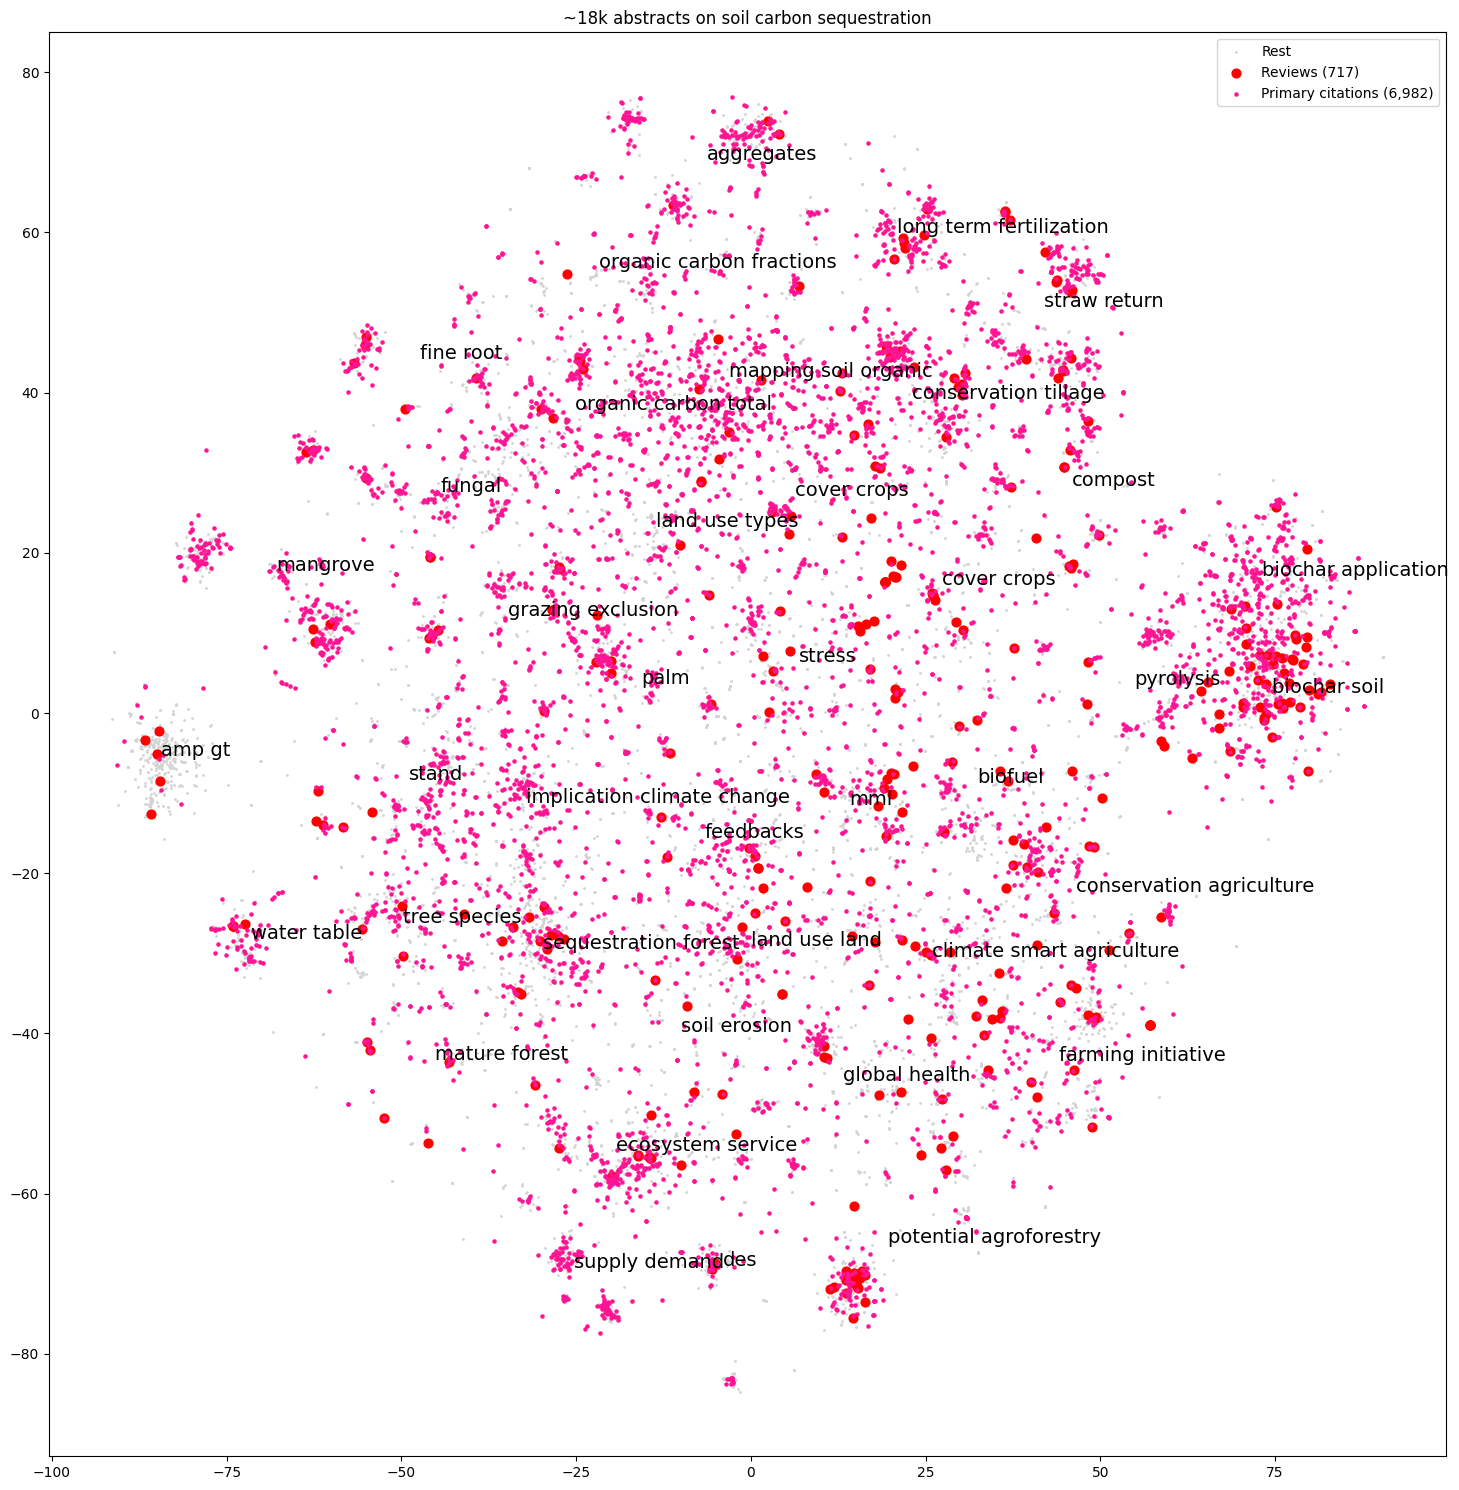

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.set_title('~18k abstracts on soil carbon sequestration')
rows = df[(df['referenced_sec'] == False) & (df['referenced'] == False) & (df['review'] == False)]
ax.scatter(rows['x'], rows['y'], s=1, c='lightgrey', label='Rest')
rows = df[(df['referenced_sec'] == False) & (df['referenced'] == False) & (df['review'] == True)]
ax.scatter(rows['x'], rows['y'], s=40, c='red', label='Reviews (717)')
rows = df[(df['referenced'] == True) & (df['review'] == False)]
ax.scatter(rows['x'], rows['y'], s=5, c='deeppink', label='Primary citations (6,982)')
ax.legend()

for ci, kwds in enumerate(cluster_keywords):
    centroid = [kmeans.cluster_centers_[ci, 0], kmeans.cluster_centers_[ci, 1]]
    plt.text(centroid[0], centroid[1], kwds[0][0], fontsize=14)
fig.tight_layout()
fig.savefig('data/figures/review_map3.png', dpi=120)

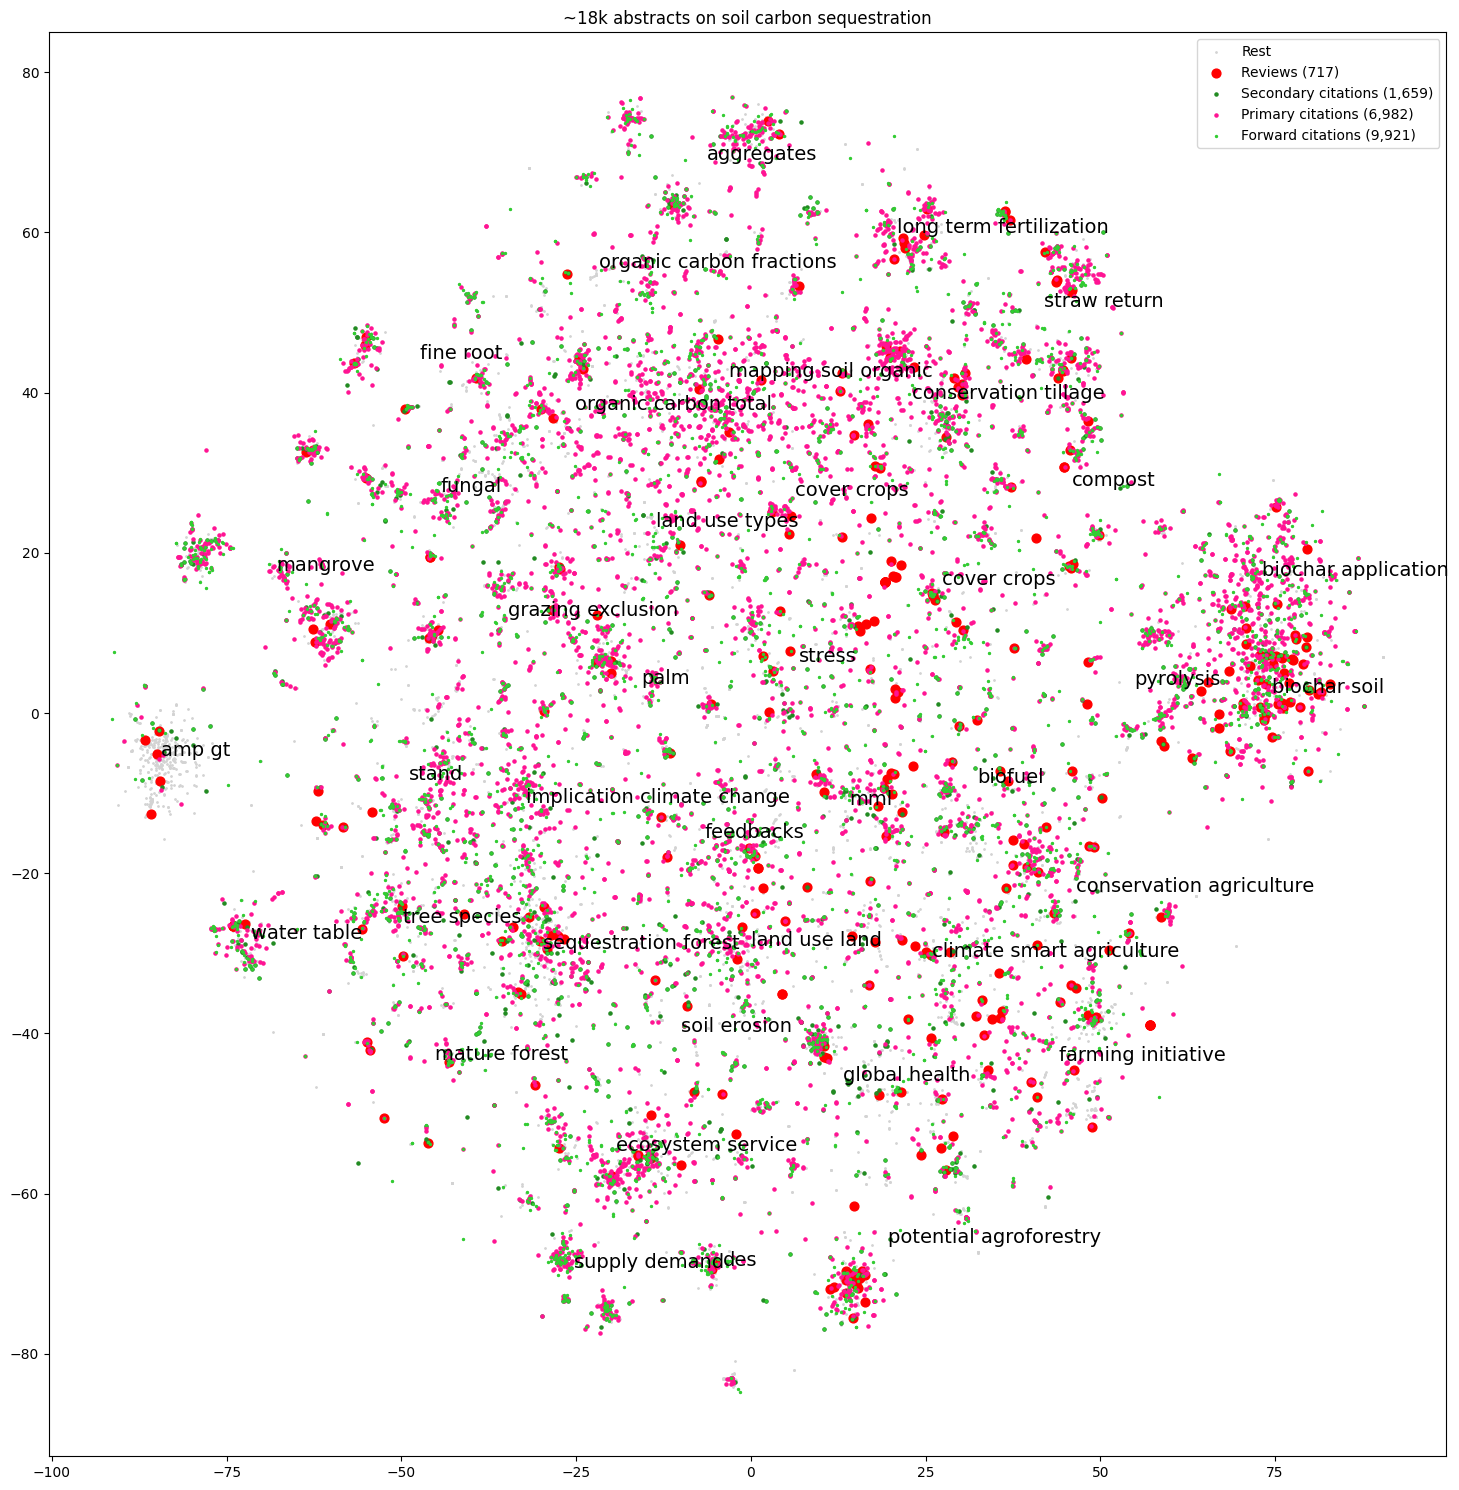

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.set_title('~18k abstracts on soil carbon sequestration')
rows = df[(df['referenced_sec'] == False) & (df['referenced'] == False) & (df['review'] == False)]
ax.scatter(rows['x'], rows['y'], s=1, c='lightgrey', label='Rest')
rows = df[(df['referenced_sec'] == False) & (df['referenced'] == False) & (df['review'] == True)]
ax.scatter(rows['x'], rows['y'], s=40, c='red', label='Reviews (717)')
rows = df[(df['referenced_sec'] == True) & (df['referenced'] == False) & (df['review'] == False)]
ax.scatter(rows['x'], rows['y'], s=5, c='forestgreen', label='Secondary citations (1,659)')
rows = df[(df['referenced'] == True) & (df['review'] == False)]
ax.scatter(rows['x'], rows['y'], s=5, c='deeppink', label='Primary citations (6,982)')
rows = df[(df['referenced_fwd'] == True) & (df['referenced'] == False) & (df['review'] == False)]
ax.scatter(rows['x'], rows['y'], s=2, c='limegreen', label='Forward citations (9,921)')
ax.legend()

for ci, kwds in enumerate(cluster_keywords):
    centroid = [kmeans.cluster_centers_[ci, 0], kmeans.cluster_centers_[ci, 1]]
    plt.text(centroid[0], centroid[1], kwds[0][0], fontsize=14)
fig.tight_layout()

fig.savefig('data/figures/review_map2.png', dpi=120)

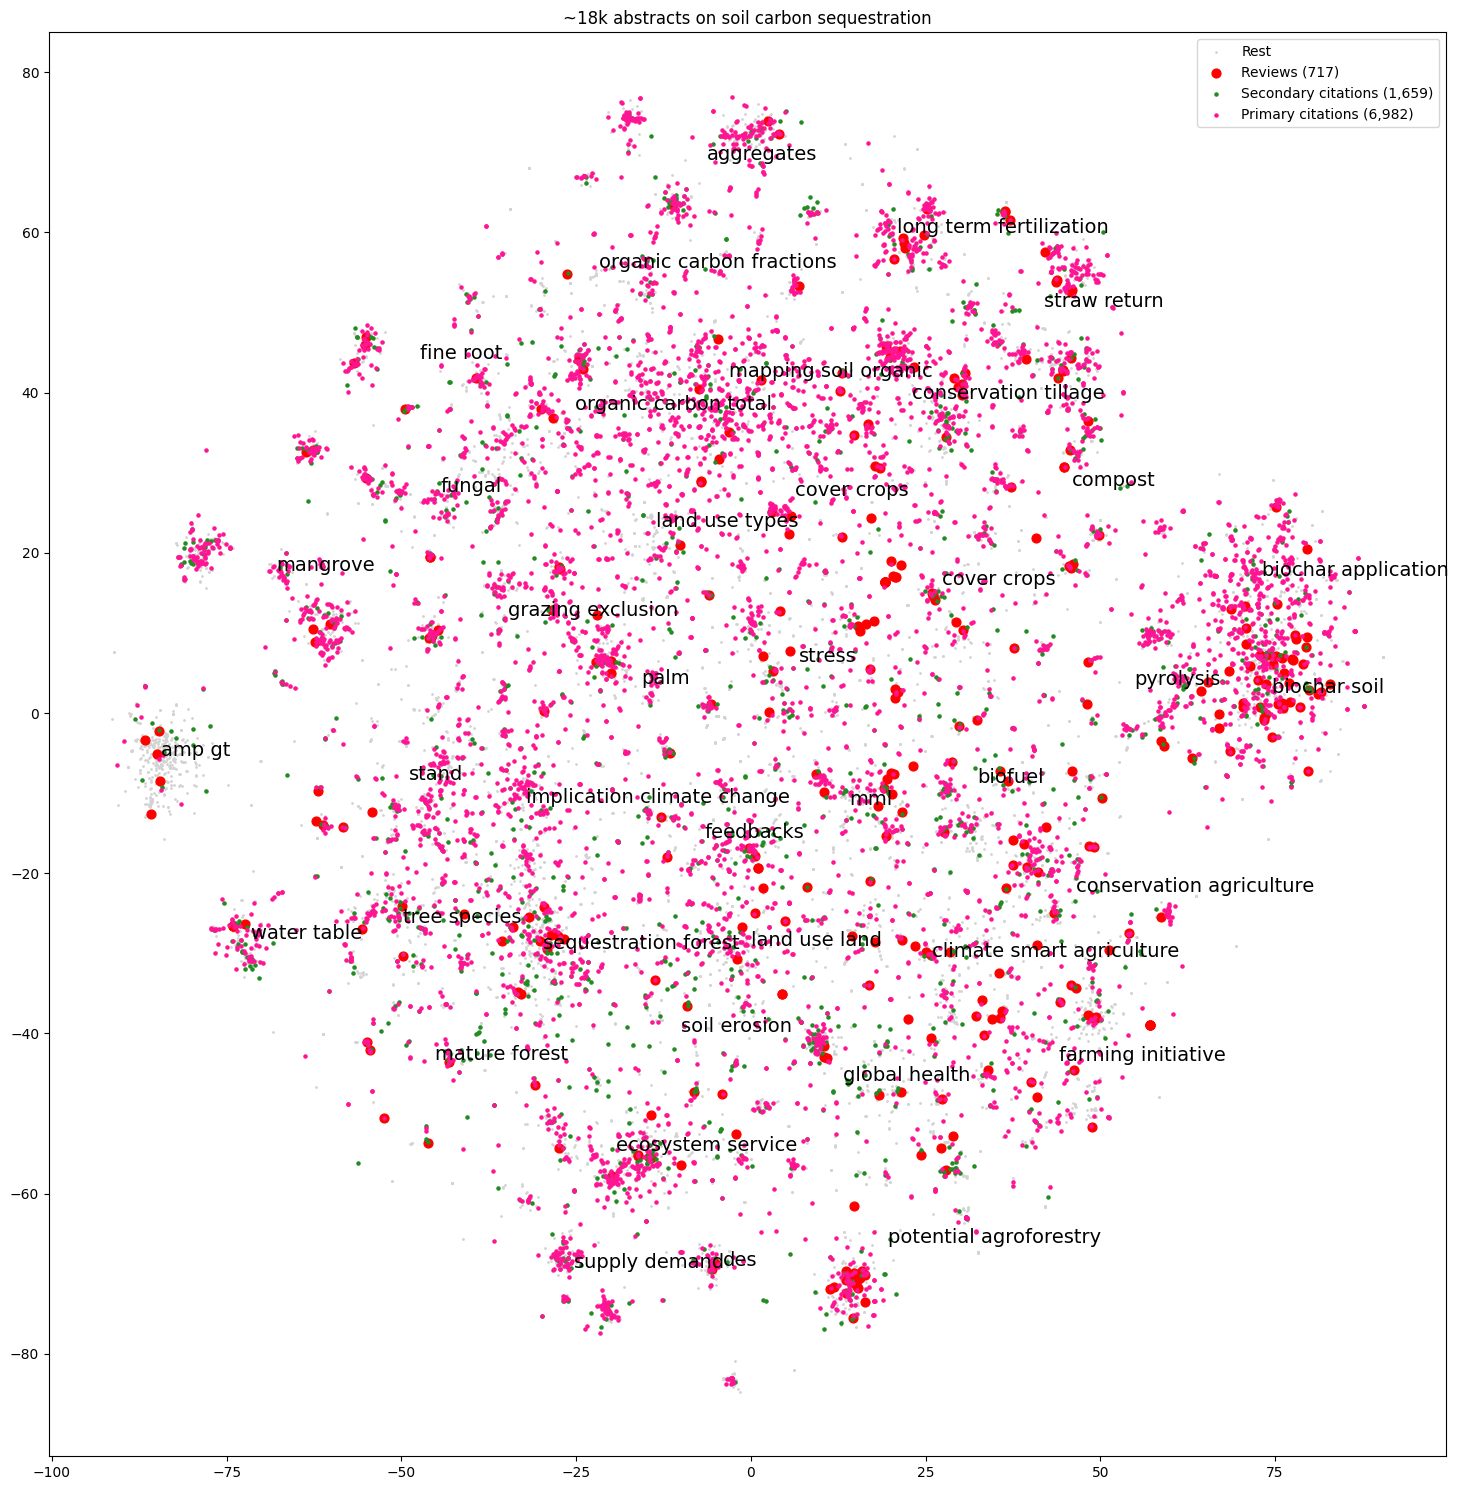

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.set_title('~18k abstracts on soil carbon sequestration')
rows = df[(df['referenced_sec'] == False) & (df['referenced'] == False) & (df['review'] == False)]
ax.scatter(rows['x'], rows['y'], s=1, c='lightgrey', label='Rest')
rows = df[(df['referenced_sec'] == False) & (df['referenced'] == False) & (df['review'] == True)]
ax.scatter(rows['x'], rows['y'], s=40, c='red', label='Reviews (717)')
rows = df[(df['referenced_sec'] == True) & (df['referenced'] == False) & (df['review'] == False)]
ax.scatter(rows['x'], rows['y'], s=5, c='forestgreen', label='Secondary citations (1,659)')
rows = df[(df['referenced'] == True) & (df['review'] == False)]
ax.scatter(rows['x'], rows['y'], s=5, c='deeppink', label='Primary citations (6,982)')
ax.legend()

for ci, kwds in enumerate(cluster_keywords):
    centroid = [kmeans.cluster_centers_[ci, 0], kmeans.cluster_centers_[ci, 1]]
    plt.text(centroid[0], centroid[1], kwds[0][0], fontsize=14)
fig.tight_layout()
fig.savefig('data/figures/review_map1.png', dpi=120)

In [115]:
for ci, keywords in enumerate(cluster_keywords):
    print(ci)
    print([kw for kw, _ in keywords])

0
['n2o', 'n2o emissions', 'nitrous oxide', 'nitrous', 'till', 'oxide emissions', 'nitrous oxide emissions', 'methane', 'till management', 'ch4 n2o', 'legume', 'net greenhouse', 'till agriculture', 'n2o emission', 'ch4']
1
['tree species', 'altitudinal', 'implication climate change', 'implication climate', 'afromontane', 'forest carbon', 'natural forests', 'coal', 'reclamation', 'forest ecosystem', 'forest reserve', 'post mining', 'ethiopia implication climate', 'deciduous', 'tree species soil']
2
['mapping soil organic', 'changes soil organic', 'prediction soil organic', 'mapping soil', 'prediction soil', 'potential cropland', 'topsoil organic', 'topsoil organic carbon', 'explicit', 'spatially explicit', 'spatial prediction soil', 'spatial prediction', 'map', 'infrared', 'nonstationary spatial']
3
['agroforestry systems', 'sequestration agroforestry', 'carbon sequestration agroforestry', 'potential agroforestry', 'based agroforestry', 'sequestration agroforestry systems', 'potential a

In [116]:
df[df['cluster']==10]

id                                       display_name  \
566    W4389264308  How much organic carbon could the soil store? ...   
668    W4388747395  Carbon sequestration and soil nitrogen enrichm...   
767    W4388312815  Carbon Farming and Its Impact on Agricultural ...   
947    W4387268791  ESTIMACIÓN DE BIOMASA Y CARBONO ALMACENADO EN ...   
959    W4387216669  Carbon Stock, Carbon Fraction and Nitrogen Fra...   
...            ...                                                ...   
16426  W1996695349  &amp;lt;i&amp;gt;Acacia trotilis&amp;lt;/i&amp...   
16433  W1996390301  Carbon balance of a three crop succession over...   
16750  W1975873443  Variations in Soil Carbon Stocks with Texture ...   
17009  W1918729039  In-Field Management Practices for Mitigating S...   
17412  W1546551119  Short Report: Effects of Biochar Addition on M...   

                                                   title  \
566    How much organic carbon could the soil store? ...   
668    Carbon sequestration and soil nitrogen enrichm...   
767    Carbon Farming and Its Impact on Agricultural ...   
947    ESTIMACIÓN DE BIOMASA Y CARBONO ALMACENADO EN ...   
959    Carbon Stock, Carbon Fraction and Nitrogen Fra...   
...                                                  ...   
16426  &amp;lt;i&amp;gt;Acacia trotilis&amp;lt;/i&amp...   
16433  Carbon balance of a three crop succession over...   
16750  Variations in Soil Carbon Stocks with Texture ...   
17009  In-Field Management Practices for Mitigating S...   
17412  Short Report: Effects of Biochar Addition on M...   

                                                abstract  \
566    Abstract Soil is a huge carbon (C) reservoir, ...   
668    Robinia pseudoacacia L. (black locust) has bee...   
767    &lt;div class="section abstract"&gt;&lt;div cl...   
947    &lt;p&gt;&lt;strong&gt;Background.&lt;/strong&...   
959    &lt;span lang="EN-US"&gt;The type of vegetatio...   
...                                                  ...   
16426  Very little is known about the type and mix of...   
16433  Long term flux measurements of different crop ...   
16750  &lt;p&gt;Australia’s land managers will need s...   
17009  The United States continues to be the largest ...   
17412  Recent interests in biochar stem from its agro...   

                                          title_abstract  \
566    How much organic carbon could the soil store? ...   
668    Carbon sequestration and soil nitrogen enrichm...   
767    Carbon Farming and Its Impact on Agricultural ...   
947    ESTIMACIÓN DE BIOMASA Y CARBONO ALMACENADO EN ...   
959    Carbon Stock, Carbon Fraction and Nitrogen Fra...   
...                                                  ...   
16426  &amp;lt;i&amp;gt;Acacia trotilis&amp;lt;/i&amp...   
16433  Carbon balance of a three crop succession over...   
16750  Variations in Soil Carbon Stocks with Texture ...   
17009  In-Field Management Practices for Mitigating S...   
17412  Short Report: Effects of Biochar Addition on M...   

                                             authorships  \
566    [{"author":{"display_name":"Raphael A. Viscarr...   
668    [{"author":{"display_name":"Giorgos Xanthopoul...   
767    [{"author":{"display_name":"Johannes Lehmann",...   
947    [{"author":{"display_name":"Fernando Carrillo ...   
959    [{"author":{"display_name":"Lintang Panjali Si...   
...                                                  ...   
16426  [{"author":{"display_name":"Taoufik Ksiksi","i...   
16433  [{"author":{"display_name":"Pierre Béziat","id...   
16750  [{"author":{"display_name":"Peter Frank Heywoo...   
17009  [{"author":{"display_name":"Sam Dennis","id":"...   
17412  [{"author":{"display_name":"Xuhui Jia","id":"h...   

                                                  biblio  \
566                          {"volume":"30","issue":"1"}   
668                                       {"volume":"6"}   
767                                                  NaN   
947            